In [104]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import warnings
import re

In [105]:
warnings.filterwarnings("ignore", message="Workbook contains no default style, apply openpyxl's default")

In [106]:
def getDataFrames(directory):
    """
    Generate dataframe dictionary given a path
    
    :param directory: String of path.
    """
    dataframes = {}
    for filename in os.listdir(directory):
        if filename.endswith('.xlsx'):
            try:
                file_path = os.path.join(directory, filename)
                key = filename[:-5]
                dataframes[key] = pd.read_excel(file_path, engine="openpyxl")
            except Exception as e:
                print(f"Error reading {filename}: {e}")
        
    return dataframes

In [107]:
def getDataFramesReport(dataframesDictionary, report_type='patient', target='all'):
    """
    Generate reports with analysis based on the specified report type and specific columns.
    
    :param dataframesDictionary: The dictionary containing patient data organized by keys.
    :param report_type: The type of report to generate ('patient', 'experiment', or 'leg').
    :param target: The specific target for the report (e.g., a patient ID for 'patient' report type).
    """
    
    def basic_stats(data):
        """Compute basic statistics for a given dataset."""
        return {
            'mean': np.mean(data),
            'std': np.std(data),
            'min': np.min(data),
            'max': np.max(data),
            'median': np.median(data)
        }

    def detect_outliers_iqr(data):
        """Detect outliers using the Interquartile Range (IQR) method."""
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        return np.where((data < lower_bound) | (data > upper_bound))

    def plot_data(time_data, data, title, patient_id):
        """Plot time series data and save the plot to a patient-specific directory."""
        # Construct the directory path
        directory = os.path.join("../Images", patient_id)
        
        # Check if the directory exists, and create it if it doesn't
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.figure(figsize=(10, 6))
        
        # Convert time_data if it contains datetime.time objects
        if isinstance(time_data.iloc[0], time):
            time_data = time_data.apply(lambda t: datetime.combine(datetime.today(), t) if t is not None else None)
        
        plt.plot(time_data, data, marker='o', linestyle='-', markersize=4)
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Sensor Reading')
    
        # Format the x-axis to show time properly if datetime objects are used
        if isinstance(time_data.iloc[0], datetime):
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
            plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
            plt.gcf().autofmt_xdate()  # Auto-format for better readability of time labels
    
        # Save the plot to a file within the patient-specific directory
        filename = os.path.join(directory, f"{title.replace(' ', '_').replace('.', '').replace('/', '')}.png")
        plt.savefig(filename)
        plt.close()  # Close the plot to free up memory
        
    # Iterate through the dataframes and perform analysis based on the report type
    for key, dataframe in dataframesDictionary.items():
        if (report_type == 'patient' and target != 'all' and key.startswith(target)) \
                or (report_type == 'experiment' and target in key[4:6]) \
                or (report_type == 'leg' and key.endswith(target.upper())) \
                or (target == 'all'):
            print(f"\nAnalyzing {key}...")
            time_data = dataframe['Time'] if 'Time' in dataframe.columns else range(len(dataframe))

            # Analyze specific sensor columns
            for column in ['MTK1.T', 'MTK2.T', 'MTK3.T', 'MTK4.T', 'MTK5.T', 'D1.T', 'L.T', 'C.T', 'MTK1.P', 'MTK2.P', 'MTK3.P', 'MTK4.P', 'MTK5.P', 'D1.P', 'L.P', 'C.P']:
                if column in dataframe.columns:
                    sensor_data = dataframe[column].dropna()
                    stats = basic_stats(sensor_data)
                    outliers_indices = detect_outliers_iqr(sensor_data)

                    print(f"{column} - Mean: {stats['mean']:.2f}, Std: {stats['std']:.2f}, Min: {stats['min']}, Max: {stats['max']}, Median: {stats['median']}")
                    print(f"Outliers detected at indices: {outliers_indices[0]}")

                    patient_id = key.split('_')[0]  # Assuming key format is 'patientid_experiment_leg'
                    plot_data(time_data, sensor_data, f"{key} - {column} Sensor Readings", patient_id)


In [108]:
# This takes awhile
diabetic_directory = '../DiabGr'
control_directory = '../ContrGr'

diabetic_frames = getDataFrames(diabetic_directory)
control_frames = getDataFrames(control_directory)


In [109]:
def normalCurve(x, mean, sd):
    prob_density = 1/(sd*(2*np.pi)**0.5) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

def makeSmooth(nparray: np.ndarray, blurSize: float = 8):
    kernel: list[float] = [normalCurve(i-blurSize, 0, blurSize/3) for i in range(2*blurSize + 1)]
    return np.convolve(np.concatenate((np.array([nparray[0] for _ in range(blurSize)]), nparray, np.array([nparray[-1] for _ in range(blurSize)]))), kernel)[2*blurSize:-2*blurSize]

def rollingMean(nparray: np.ndarray, blurSize: float = 4):
    kernel: list[float] = [1/(2*blurSize+1) for i in range(2*blurSize + 1)]
    return np.convolve(np.concatenate((np.array([nparray[0] for _ in range(blurSize)]), nparray, np.array([nparray[-1] for _ in range(blurSize)]))), kernel)[2*blurSize:-2*blurSize]

def rollingMedian(df: pd.DataFrame, windowSize: float = 7):
    return df.rolling(windowSize).median()

def rollingStandardDeviation(df: pd.DataFrame, windowSize: float = 7):
    return df.rolling(windowSize).std()

def makeTangent(nparray: np.ndarray):
    result = np.zeros(len(nparray))
    for i in range(len(nparray) - 1):
        result[i] = nparray[i + 1] - nparray[i]
    result[-1] = result[-2]
    return result



In [110]:
# df = diabetic_frames[next(diabetic_frames.__iter__())]
it = diabetic_frames.__iter__()
# next(it)
df = diabetic_frames[next(it)]


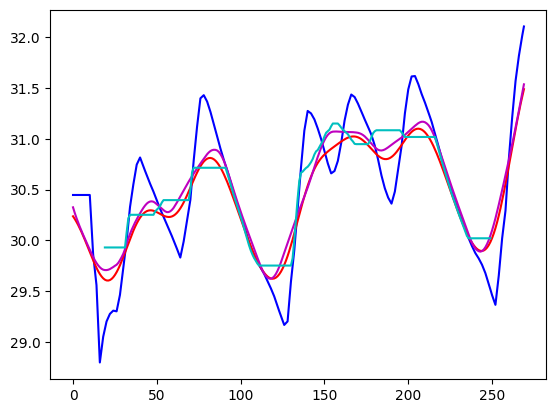

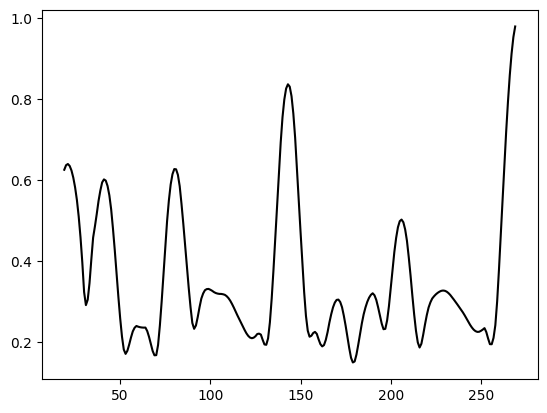

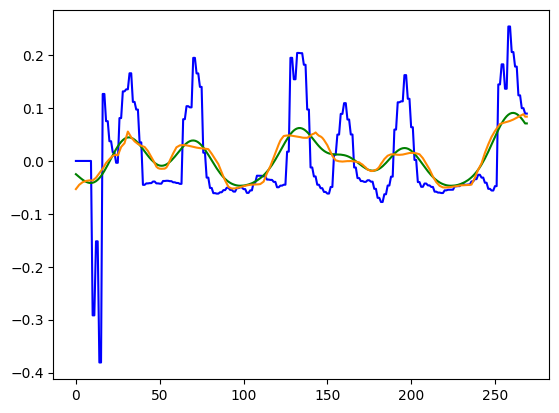

In [111]:
yDF = df.iloc[:, 6]
yNP = yDF.to_numpy()
y = yNP.tolist()
plt.plot([x for x in range(len(y))], y, c='b')
ySm = makeSmooth(yNP, 30)
plt.plot([x for x in range(len(y))], ySm.tolist(), c='r')
yRm = rollingMean(yNP, 15)
plt.plot([x for x in range(len(y))], yRm.tolist(), c='m')
yMed = rollingMedian(yDF, 40)
plt.plot([x for x in range(len(y))], yMed.to_numpy().tolist()[20:] + [None for _ in range(20)], c='c')
plt.show()


yStd = rollingStandardDeviation(yDF, 20)
plt.plot([x for x in range(len(y))], yStd.to_numpy().tolist(), c='k')
plt.show()



yNTn = makeTangent(yNP)
plt.plot([x for x in range(len(y))], yNTn.tolist(), c='b')
ySTn = makeTangent(ySm)
plt.plot([x for x in range(len(y))], ySTn.tolist(), c='g')
yRTn = makeTangent(yRm)
plt.plot([x for x in range(len(y))], yRTn.tolist(), c='#ff8800')
plt.show()

In [47]:
getDataFramesReport(diabetic_frames, target='all')


Analyzing P001T01R...
MTK1.T - Mean: 26.49, Std: 1.87, Min: 23.66515344832763, Max: 29.68701838150484, Median: 26.154325808439037
Outliers detected at indices: []
MTK2.T - Mean: 27.04, Std: 2.06, Min: 23.67040409070536, Max: 30.32160750066923, Median: 26.70425913235536
Outliers detected at indices: []
MTK3.T - Mean: 27.85, Std: 2.37, Min: 23.798296858393684, Max: 31.217234018992748, Median: 27.57165493192037
Outliers detected at indices: []
MTK4.T - Mean: 28.57, Std: 2.55, Min: 24.064021151711575, Max: 31.700000000000006, Median: 28.74050863882715
Outliers detected at indices: []
MTK5.T - Mean: 28.30, Std: 2.59, Min: 23.86038727900117, Max: 31.410496281279805, Median: 28.827832061590144
Outliers detected at indices: []
D1.T - Mean: 26.28, Std: 1.96, Min: 23.166000980526096, Max: 29.305883835032855, Median: 26.05133985023391
Outliers detected at indices: []
L.T - Mean: 28.70, Std: 2.25, Min: 24.453311008284295, Max: 31.65956746785734, Median: 28.91281205475628
Outliers detected at indi

In [48]:
getDataFramesReport(control_frames, target='all')


Analyzing P075T01L...
MTK1.T - Mean: 241.54, Std: 0.28, Min: 240.78651998848616, Max: 241.87806728708574, Median: 241.6821012216197
Outliers detected at indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60]
MTK2.T - Mean: 22.49, Std: 0.27, Min: 21.924323309293076, Max: 22.963498688096475, Median: 22.60835256142837
Outliers detected at indices: []
MTK3.T - Mean: 22.33, Std: 0.22, Min: 21.86287513471674, Max: 22.72094035219779, Median: 22.41427382487724
Outliers detected at indices: []
MTK4.T - Mean: 22.39, Std: 0.20, Min: 21.87006702467307, Max: 22.71146696439496, Median: 22.412390286189968
Outliers detected at indices: []
MTK5.T - Mean: 22.16, Std: 0.21, Min: 21.557346218089165, Max: 22.404420003942327, Median: 22.234199430690328
Outliers detected at indices: [153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171]
D1.T - M

In [20]:
diabetic_frames['P016T01R'].columns

Index(['Unnamed: 0', 'Time', 'Date', 'MTK1.T', 'MTK2.T', 'MTK3.T', 'MTK4.T',
       'MTK5.T', 'D1.T', 'L.T', 'C.T', 'Env.T', 'MTK1.P', 'MTK2.P', 'MTK3.P',
       'MTK4.P', 'MTK5.P', 'D1.P', 'L.P', 'C.P'],
      dtype='object')

In [15]:
diabetic_frames['P001T01R'].shape

(290, 20)